In [1]:
import os
import tflearn
from glob import glob
from skimage import color, io
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

%matplotlib inline

In [2]:
size_image =32

allX = np.zeros((100, size_image, size_image, 3), dtype='float32')
ally = np.zeros(100)
count = 0

#cat images and labels
for i in range(49):
        img = io.imread("cat/cat"+str(i+1)+".jpg")
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 0
        count += 1

#dog images and labels
for i in range(51):
        img = io.imread("dog/dog"+str(i+1)+".jpg")
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 1
        count += 1


print("number of images :", len(allX))
print("number of labels :", len(ally))
print("shape of image :", allX[20].shape)
print("all labels :", ally)

('number of images :', 100)
('number of labels :', 100)
('shape of image :', (32, 32, 3))
('all labels :', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


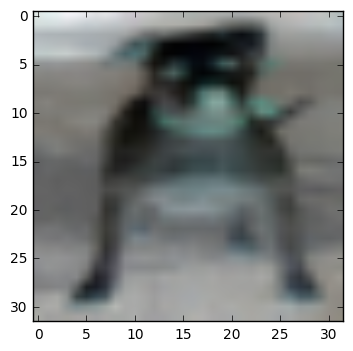

In [3]:
plt.imshow(allX[90])

In [4]:
#splitting dataset supaya random
X, X_test, Y, Y_test = train_test_split(allX, ally, test_size=0.1, random_state=42)

print('number of training data :',len(X), 'number of training labels :', len(Y))
print('number of testing data :',len(X_test), 'number of testing labels :',len(Y_test))
print(Y_test)

('number of training data :', 90, 'number of training labels :', 90)
('number of testing data :', 10, 'number of testing labels :', 10)
[ 1.  1.  1.  0.  0.  0.  0.  1.  0.  0.]


In [5]:
# encode the Ys
Y = to_categorical(Y, 2)
Y_test = to_categorical(Y_test, 2)

#print(Y)
print(Y_test)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


In [6]:
# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

print(img_prep)
print(img_aug)

In [8]:
###################################
# Define network architecture
###################################

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 32, 32, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

#conv layer with filter sixe 3x3, number of filter 32 with activation relu
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')
#pooling layer with filter size 2x2
network = max_pool_2d(conv_1, 2)
#FC layer with number of neurons 512
network = fully_connected(network, 512, activation='relu')
#dropout layer to prevent overfitting
network = dropout(network, 0.5)
#final FC with classifier : softmax
network = fully_connected(network, 2, activation='softmax')

#calculate the accuracy
acc = Accuracy(name="Accuracy")
#define how network to be trained
#it uses crossentropy loss function, adam optimizer for gradient descent, learning rate 0.0005 
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_6.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')



In [11]:
# Train using classifier
model.fit(X, Y, n_epoch=50, shuffle=True, validation_set=(X_test, Y_test),
          show_metric=True, batch_size=50, run_id='dogcat_cnn')

---------------------------------
Run id: dogcat_cnn
Log directory: /tmp/tflearn_logs/
---------------------------------
Training samples: 90
Validation samples: 10
--
Training Step: 51  | total loss: 0.38489 | time: 3.911s
| Adam | epoch: 051 | loss: 0.38489 - Accuracy: 0.8564 | val_loss: 0.63783 - val_acc: 0.6000 -- iter: 90/90
--
Training Step: 52  | total loss: 0.52337 | time: 2.201s
| Adam | epoch: 052 | loss: 0.52337 - Accuracy: 0.8063 | val_loss: 0.60970 - val_acc: 0.6000 -- iter: 90/90
--
Training Step: 53  | total loss: 0.48460 | time: 1.202s
| Adam | epoch: 053 | loss: 0.48460 - Accuracy: 0.8234 | val_loss: 0.61172 - val_acc: 0.7000 -- iter: 90/90
--
Training Step: 54  | total loss: 0.50969 | time: 2.163s
| Adam | epoch: 054 | loss: 0.50969 - Accuracy: 0.8087 | val_loss: 0.62561 - val_acc: 0.6000 -- iter: 90/90
--
Training Step: 55  | total loss: 0.47691 | time: 2.157s
| Adam | epoch: 055 | loss: 0.47691 - Accuracy: 0.8281 | val_loss: 0.63794 - val_acc: 0.6000 -- iter: 90/90
